# 教育投资效率分析

本notebook分析欧盟国家的教育投资效率，通过比较人均GDP和教育投资来评估各国的投资效率。

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pymongo import MongoClient
import os
from dotenv import load_dotenv

# 加载环境变量
load_dotenv()

True

In [2]:
def load_and_process_data():
    """加载和处理教育与经济数据"""
    # 加载原始数据
    education_data = pd.read_csv('../data/cache/education_investment.csv')
    economic_data = pd.read_csv('../data/cache/economic_indicators.csv')
    
    # 将教育数据从宽格式转换为长格式
    id_vars = ['index', 'freq', 'unit', 'isced11', 'geo\\TIME_PERIOD', 'collected_at', 'source']
    value_vars = [str(year) for year in range(2012, 2022)]  # 2012-2021年
    
    education_data_long = pd.melt(
        education_data,
        id_vars=id_vars,
        value_vars=value_vars,
        var_name='year',
        value_name='value'
    )
    
    # 清理和准备教育数据
    education_data_cleaned = education_data_long.copy()
    education_data_cleaned['year'] = pd.to_numeric(education_data_cleaned['year'])
    education_data_cleaned['value'] = pd.to_numeric(education_data_cleaned['value'], errors='coerce')
    education_data_cleaned = education_data_cleaned.rename(columns={'geo\\TIME_PERIOD': 'geo_time_period'})
    
    # 清理经济数据
    economic_data['year'] = pd.to_numeric(economic_data['year'])
    economic_data['gdp_per_capita'] = pd.to_numeric(economic_data['gdp_per_capita'], errors='coerce')
    
    # 创建国家代码映射
    country_mapping = {
        'AT': 'AUT', 'BE': 'BEL', 'BG': 'BGR', 'CY': 'CYP', 'CZ': 'CZE',
        'DE': 'DEU', 'DK': 'DNK', 'EE': 'EST', 'ES': 'ESP', 'FI': 'FIN',
        'FR': 'FRA', 'GR': 'GRC', 'HR': 'HRV', 'HU': 'HUN', 'IE': 'IRL',
        'IT': 'ITA', 'LT': 'LTU', 'LU': 'LUX', 'LV': 'LVA', 'MT': 'MLT',
        'NL': 'NLD', 'PL': 'POL', 'PT': 'PRT', 'RO': 'ROU', 'SE': 'SWE',
        'SI': 'SVN', 'SK': 'SVK'
    }
    
    # 映射教育数据中的国家代码
    education_data_cleaned['country_code'] = education_data_cleaned['geo_time_period'].map(country_mapping)
    
    # 对每个国家和年份的教育投资进行聚合（取平均值）
    education_data_agg = education_data_cleaned.groupby(
        ['country_code', 'year', 'geo_time_period']
    )['value'].mean().reset_index()
    
    # 合并数据集
    merged_data = pd.merge(
        education_data_agg,
        economic_data[['country_code', 'year', 'gdp_per_capita']],
        on=['country_code', 'year'],
        how='inner'
    )
    
    return education_data_cleaned, merged_data

In [3]:
def plot_investment_efficiency(merged_data, output_dir='../visualizations'):
    """绘制投资效率分析图表"""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    if not merged_data.empty:
        # 计算效率
        merged_data['investment_efficiency'] = merged_data['gdp_per_capita'] / merged_data['value']
        
        # 移除无限值和空值
        merged_data = merged_data.replace([np.inf, -np.inf], np.nan).dropna(subset=['investment_efficiency'])
        
        latest_year = merged_data['year'].max()
        print(f"\n分析 {latest_year} 年数据")
        
        latest_efficiency = merged_data[merged_data['year'] == latest_year]
        print(f"最新年份的国家数量: {len(latest_efficiency)}")
        
        if not latest_efficiency.empty:
            # 确保每个国家只取一个最高效率值
            top_efficient = latest_efficiency.sort_values('investment_efficiency', ascending=False)
            top_efficient = top_efficient.drop_duplicates(subset=['geo_time_period'], keep='first')
            top_efficient = top_efficient.head(5)
            
            plt.figure(figsize=(12, 6))
            sns.barplot(data=top_efficient, x='geo_time_period', y='investment_efficiency')
            plt.title(f'Investment Efficiency Top 5 Countries ({latest_year})')
            plt.xlabel('Country')
            plt.ylabel('Efficiency Ratio (GDP per capita / Investment)')
            plt.xticks(rotation=45)
            plt.tight_layout()
            
            # 保存图表
            output_path = os.path.join(output_dir, 'investment_efficiency.png')
            plt.savefig(output_path)
            plt.show()
            
            print(f"\n投资效率最高的前5个国家:")
            for _, row in top_efficient.iterrows():
                print(f"{row['geo_time_period']}:")
                print(f"  效率比率: {row['investment_efficiency']:.2f}")
                print(f"  人均GDP: {row['gdp_per_capita']:.2f}")
                print(f"  教育投资: {row['value']:.2f}")
        else:
            print("最新年份没有可用数据")
    else:
        print("合并后的数据为空")

正在加载和处理数据...

分析投资效率...
----------------------------------------

分析 2021 年数据
最新年份的国家数量: 26


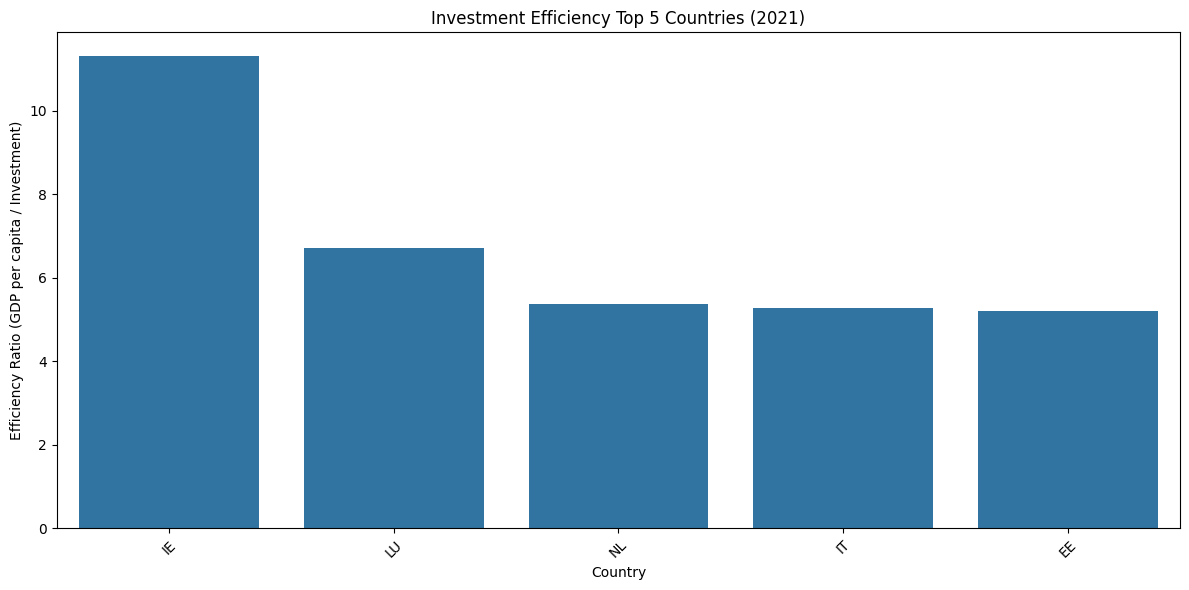


投资效率最高的前5个国家:
IE:
  效率比率: 11.31
  人均GDP: 105561.14
  教育投资: 9330.57
LU:
  效率比率: 6.72
  人均GDP: 133711.79
  教育投资: 19912.19
NL:
  效率比率: 5.38
  人均GDP: 60141.99
  教育投资: 11188.91
IT:
  效率比率: 5.28
  人均GDP: 36852.54
  教育投资: 6977.18
EE:
  效率比率: 5.21
  人均GDP: 27953.77
  教育投资: 5366.58


In [4]:
# 加载和处理数据
print("正在加载和处理数据...")
education_data_cleaned, merged_data = load_and_process_data()

# 分析投资效率并生成图表
print("\n分析投资效率...")
print("-" * 40)
plot_investment_efficiency(merged_data)